# 📌 Project: End-to-End Customer Behavior Analysis and Prediction

 - In this project, we analyze eCommerce behavioral data to understand customer purchase patterns,
 - apply RFM (Recency, Frequency, Monetary) segmentation, and build a predictive model for purchases.


In [9]:
# ! pip install pandas numpy matplotlib seaborn scikit-learn xgboost shap 

## 1. 🛠️ Library Imports

In [4]:
# Standard Library
import os
import json
import warnings
from datetime import datetime

# Data Handling
import duckdb
import numpy as np
import pandas as pd
import pyarrow.parquet as pq

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Progress Display
from tqdm import tqdm

# Machine Learning - Scikit-Learn
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn import preprocessing 
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV
)
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 
from sklearn.metrics import (
    classification_report,
    precision_recall_curve,
    average_precision_score,
    confusion_matrix,
    precision_score,
    roc_auc_score,
    recall_score,
    roc_curve,
    auc
)

# Machine Learning - External
import xgboost as xgb
import shap

# Model Persistence
import joblib

# Silence warnings
warnings.filterwarnings("ignore")


In [5]:
# Configure visualization defaults
plt.style.use('seaborn-v0_8')  # Or another available seaborn style
sns.set_palette('husl')
pd.options.display.float_format = '{:,.2f}'.format
tqdm.pandas()

## 2. 📥 Data Loading & Initial Exploration

In [ ]:
# file_path1 = r"D:\Learnings\My_Projects\Datasets\eCommerce behavior data 2019-Nov\eCommerce behavior data 2019-Nov.parquet"

# # Open the Parquet file
# parquet_file = pq.ParquetFile(file_path1)

# # Get total number of row groups (each can be treated as a chunk)
# num_row_groups = parquet_file.num_row_groups

# print(f"Total Row Groups: {num_row_groups}")

# # Read one chunk (row group) at a time
# for i in range(num_row_groups):
#     if i< 1:
#         df_chunk = parquet_file.read_row_group(i).to_pandas()
#         print(f"Chunk {i+1}/{num_row_groups} - Shape: {df_chunk.shape}")
    
# df_chunk.shape

Total Row Groups: 65
Chunk 1/65 - Shape: (1048576, 9)


(1048576, 9)

#### Read all rows from the Parquet file using DuckDB — it's often faster and more memory-efficient than pandas

In [ ]:
# # Point to your file
# file_path = r"D:\Learnings\My_Projects\Datasets\eCommerce behavior data 2019-Nov\eCommerce behavior data 2019-Nov.parquet"

# # Connect to DuckDB in-memory (or you can use a persistent DB file)
# con = duckdb.connect()

# # Query to select only rows without any NULLs
# query = f"""
#     SELECT *
#     FROM '{file_path}'
#     WHERE NOT ({" OR ".join([f"{col} IS NULL" for col in con.execute(f"DESCRIBE SELECT * FROM '{file_path}'").fetchdf()['column_name'].tolist()])})
# """

# # Fetch into DataFrame
# df_clean = con.execute(query).fetchdf()

# print(f"Filtered rows: {df_clean.shape}")


In [6]:
file_path = r"D:\Learnings\My_Projects\Datasets\eCommerce behavior data 2019-Nov\eCommerce behavior data 2019-Nov.parquet"
con = duckdb.connect()

# Step 1: Get list of columns to filter out NULLs
columns = con.execute(f"DESCRIBE SELECT * FROM '{file_path}'").fetchdf()['column_name'].tolist()
null_filter = " AND ".join([f"{col} IS NOT NULL" for col in columns])

# Step 2: Get top 10 most frequent category_code values
top_categories_query = f"""
    SELECT category_code
    FROM '{file_path}'
    WHERE category_code IS NOT NULL
    GROUP BY category_code
    ORDER BY COUNT(*) DESC
    LIMIT 10
"""
top_categories = con.execute(top_categories_query).fetchdf()['category_code'].tolist()

# Convert to SQL-safe IN clause
category_filter = ', '.join([f"'{cat}'" for cat in top_categories])

# Step 3: Final query with both filters
query = f"""
    SELECT *
    FROM '{file_path}'
    WHERE {null_filter}
      AND category_code IN ({category_filter})
"""

df_clean = con.execute(query).fetchdf()

print(f"Filtered rows (no NULLs, top 10 categories): {df_clean.shape}")
df_clean['category_code'].value_counts().head(10)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Filtered rows (no NULLs, top 10 categories): (30613451, 9)


category_code
electronics.smartphone              16353579
electronics.video.tv                 2195118
computers.notebook                   2164657
electronics.clocks                   1811325
electronics.audio.headphone          1803893
apparel.shoes                        1587667
appliances.environment.vacuum        1510004
appliances.kitchen.washer            1389808
appliances.kitchen.refrigerators     1149533
computers.desktop                     647867
Name: count, dtype: int64

In [7]:
df_clean.shape

(30613451, 9)

In [8]:
df_clean.head(2)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-08 02:31:12+05:30,view,21408708,2053013561579406073,electronics.clocks,casio,110.43,519907469,9033e7ca-5e6e-40e4-be4d-7efbd9e45c90
1,2019-11-08 02:31:13+05:30,view,1307136,2053013558920217191,computers.notebook,acer,514.04,553167808,a30787c3-ac18-49c1-90d3-66475cfd7184


In [9]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30613451 entries, 0 to 30613450
Data columns (total 9 columns):
 #   Column         Dtype                        
---  ------         -----                        
 0   event_time     datetime64[us, Asia/Calcutta]
 1   event_type     object                       
 2   product_id     int64                        
 3   category_id    int64                        
 4   category_code  object                       
 5   brand          object                       
 6   price          float64                      
 7   user_id        int64                        
 8   user_session   object                       
dtypes: datetime64[us, Asia/Calcutta](1), float64(1), int64(3), object(4)
memory usage: 2.1+ GB


In [10]:
df = df_clean
df.shape

(30613451, 9)

In [11]:
df.isnull().sum()

event_time       0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
dtype: int64

## 🧹 3 Data Cleaning

In [12]:
# Drop rows with missing values
# df.dropna(inplace=True)

In [13]:
# Drop duplicates, keeping the last occurrence
df = df.drop_duplicates(keep = 'last')

In [14]:
df.shape

(30553779, 9)

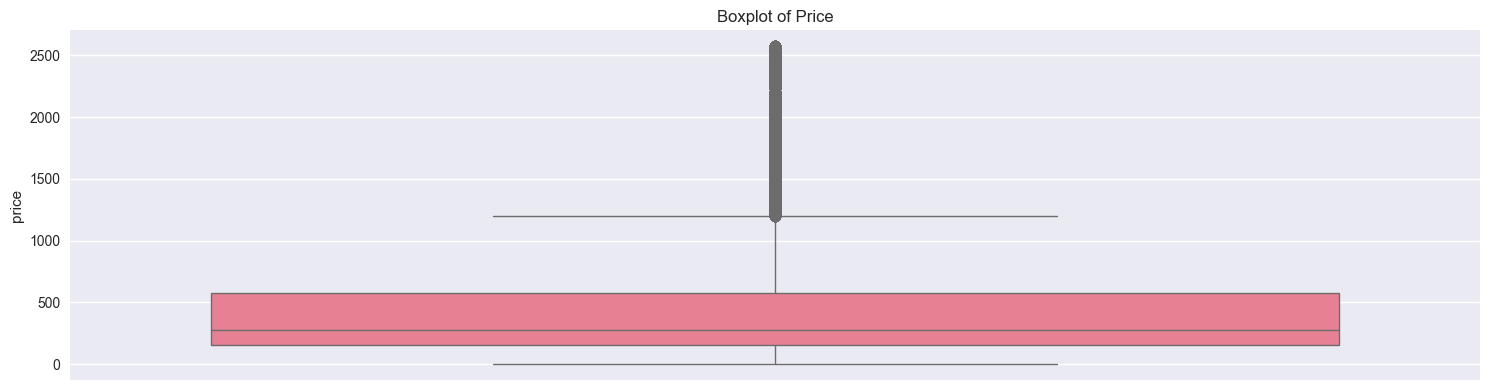

In [15]:
# Outlier Visualization using Box Plots

plt.figure(figsize=(15, 4))

sns.boxplot(y=df['price'])
plt.title('Boxplot of Price')

plt.tight_layout()
plt.show()

In [16]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Detect outliers for price features
outlier_price = detect_outliers_iqr(df, 'price')

print("Recency outliers:", len(outlier_price))


Recency outliers: 1749564


In [17]:
df.head(2)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-08 02:31:12+05:30,view,21408708,2053013561579406073,electronics.clocks,casio,110.43,519907469,9033e7ca-5e6e-40e4-be4d-7efbd9e45c90
1,2019-11-08 02:31:13+05:30,view,1307136,2053013558920217191,computers.notebook,acer,514.04,553167808,a30787c3-ac18-49c1-90d3-66475cfd7184


## 🔍 4. Exploratory Data Analysis (EDA)

In [18]:
#### Feature Exploration & Engineering for Insights

# Convert event_time to datetime
df['event_time'] = pd.to_datetime(df['event_time'])

# Extract time-based features
df['hour'] = df['event_time'].dt.hour
df['day_of_week'] = df['event_time'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)

# Handle Categorical Data for Exploration
df['category_code'] = df['category_code'].fillna('unknown')
df[['main_category', 'sub_category']] = df['category_code'].str.split('.', n=1, expand=True)

In [19]:

unique_visitor = df['user_id'].nunique()
print ("Unique Visitors: {}".format(unique_visitor))

Unique Visitors: 2373979


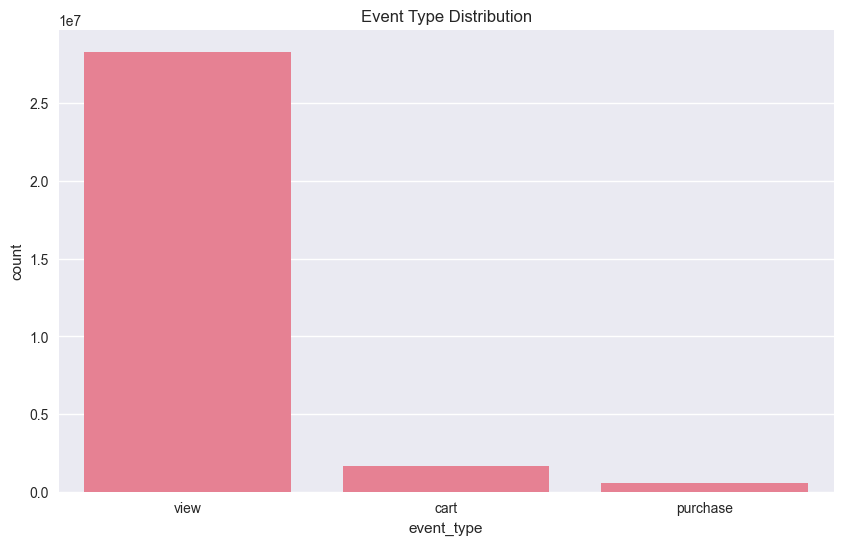

In [20]:
# Event type distribution
plt.figure(figsize=(10,6))
sns.countplot(x='event_type', data=df)
plt.title('Event Type Distribution')
plt.show()

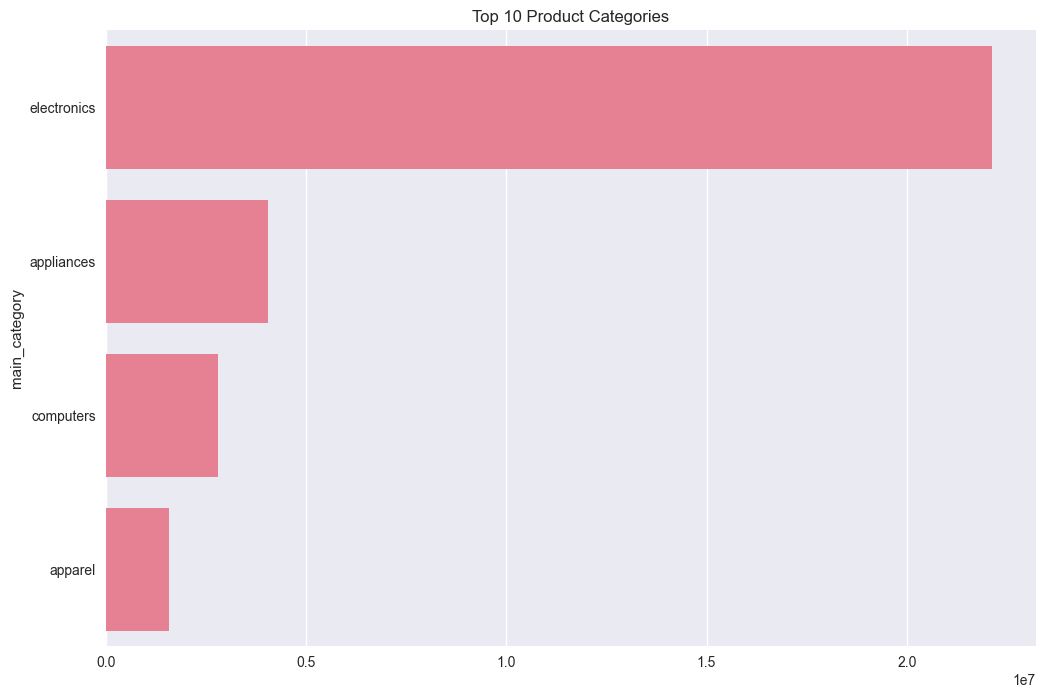

In [21]:
# Popular categories
top_categories = df['main_category'].value_counts().nlargest(10)
plt.figure(figsize=(12,8))
sns.barplot(x=top_categories.values, y=top_categories.index)
plt.title('Top 10 Product Categories')
plt.show()

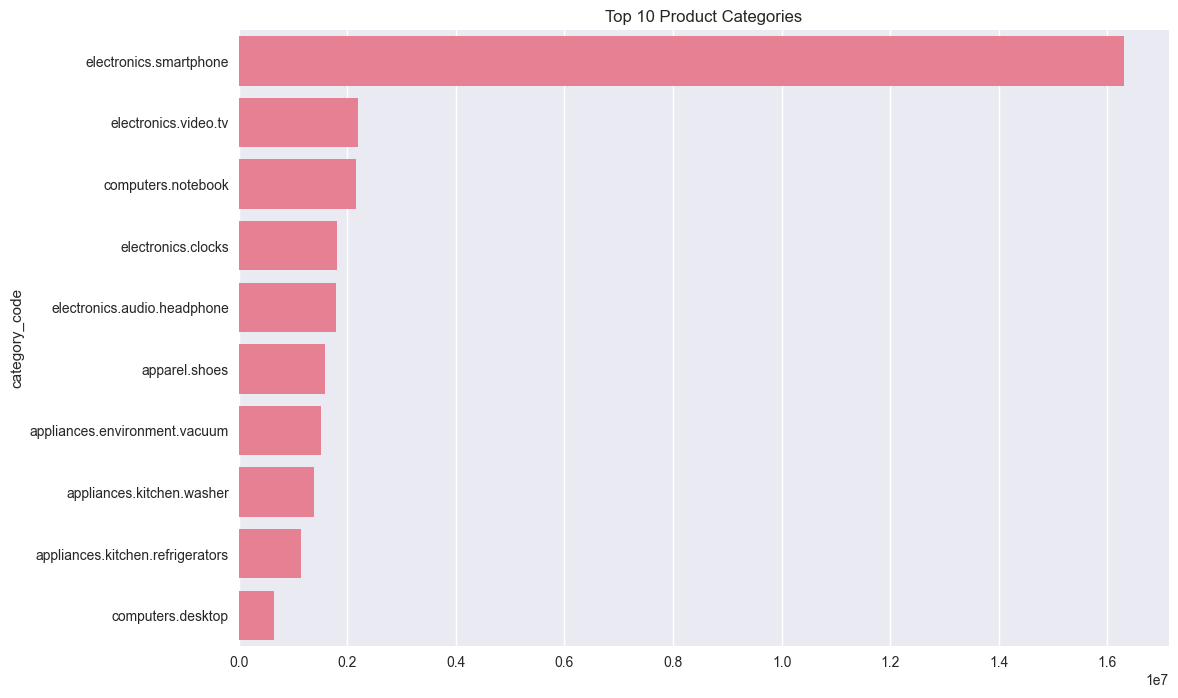

In [22]:
# Popular subcategory categories
top_categories = df['category_code'].value_counts().nlargest(10)
plt.figure(figsize=(12,8))
sns.barplot(x=top_categories.values, y=top_categories.index)
plt.title('Top 10 Product Categories')
plt.show()

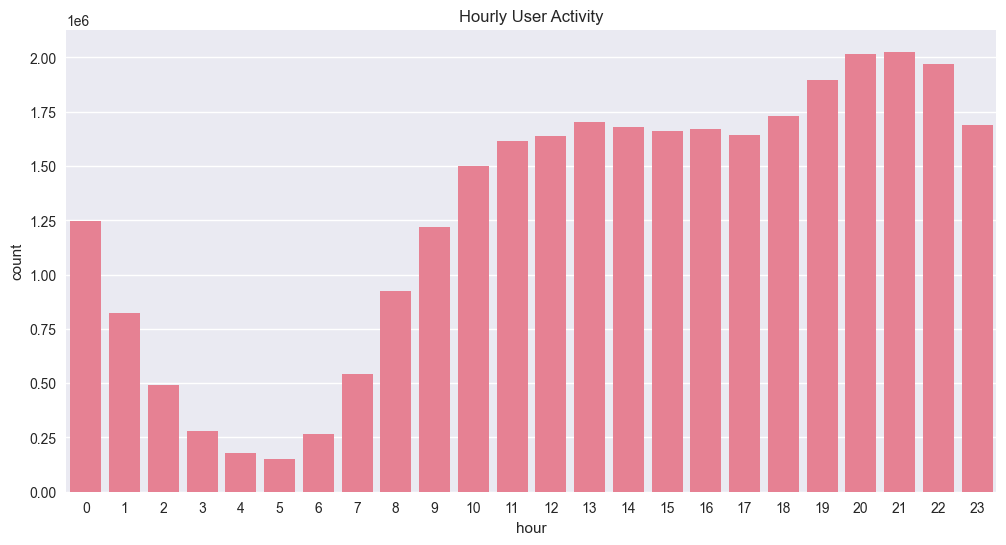

In [23]:
# User activity patterns
plt.figure(figsize=(12,6))
sns.countplot(x='hour', data=df)
plt.title('Hourly User Activity')
plt.show()

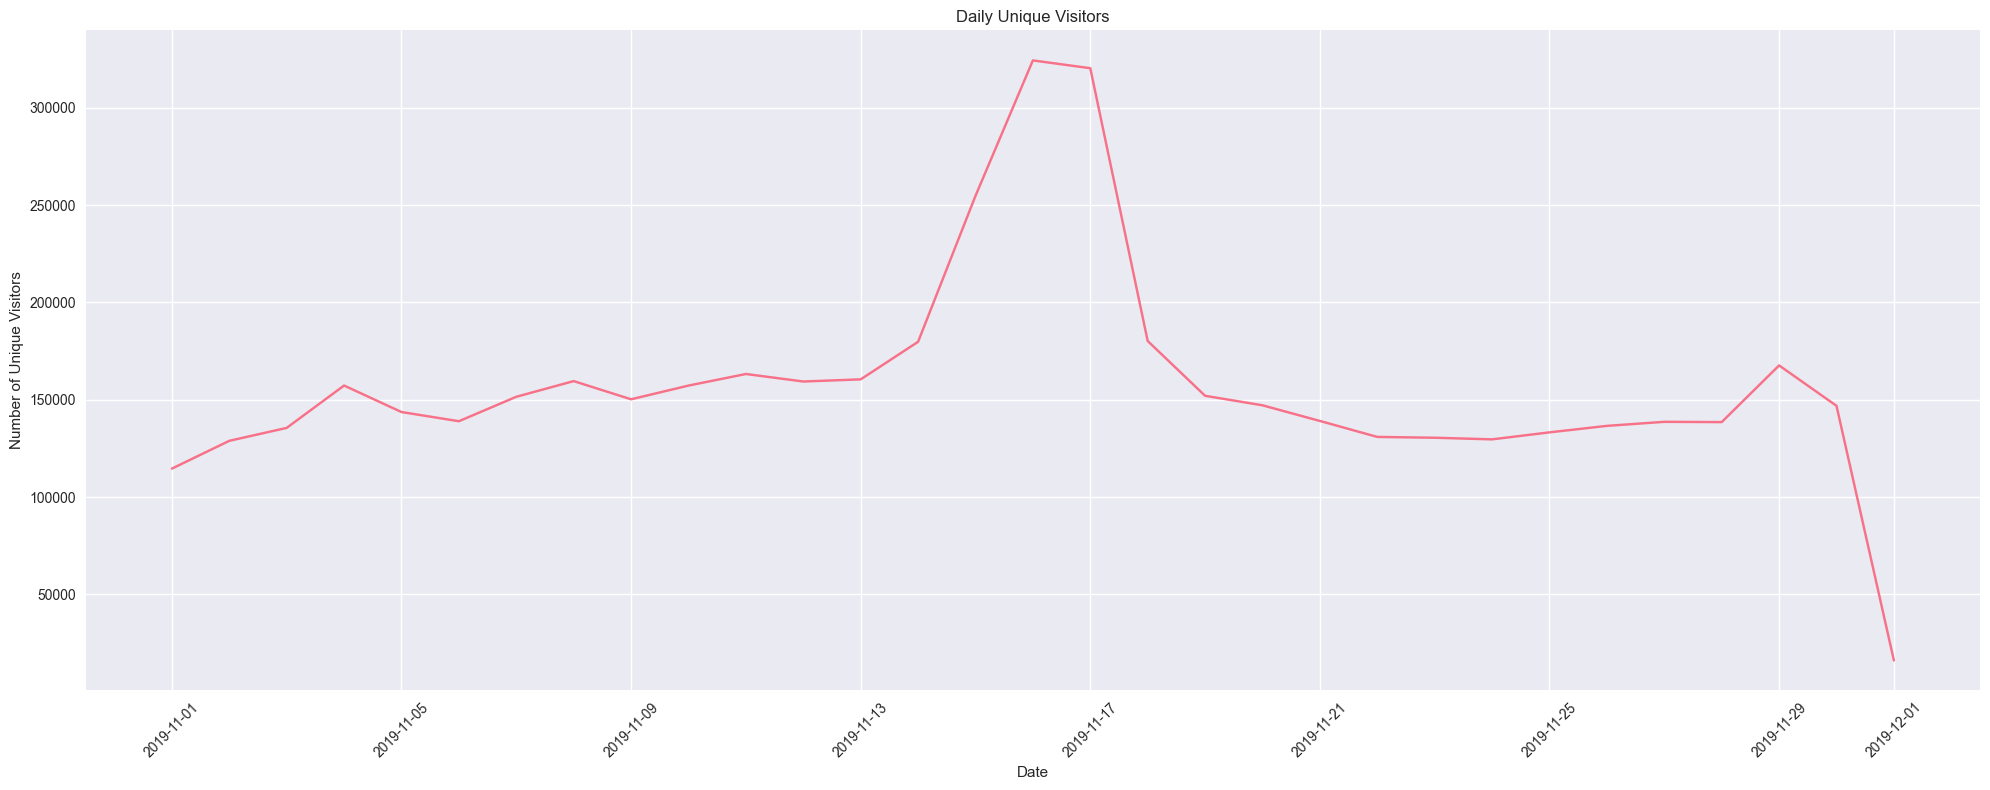

In [24]:
# Convert 'event_time' to datetime objects and extract the date
df['event_date'] = pd.to_datetime(df['event_time']).dt.date

# Count unique visitors per day
visitor_by_date = df.groupby('event_date')['user_id'].nunique().sort_index()

# Prepare data for plotting
dates = visitor_by_date.index
visitor_counts = visitor_by_date.values

# Set figure size
plt.rcParams['figure.figsize'] = (20, 8)

# Create the plot
plt.plot(dates, visitor_counts)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Number of Unique Visitors')
plt.title('Daily Unique Visitors')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [25]:
df.shape

(30553779, 15)

## 🧠 5. Feature Engineering

### 5.1 Feature Transformation and Creation

In [26]:
print("Shape: ", df.shape)
df.head(2)

Shape:  (30553779, 15)


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,hour,day_of_week,is_weekend,main_category,sub_category,event_date
0,2019-11-08 02:31:12+05:30,view,21408708,2053013561579406073,electronics.clocks,casio,110.43,519907469,9033e7ca-5e6e-40e4-be4d-7efbd9e45c90,2,4,0,electronics,clocks,2019-11-08
1,2019-11-08 02:31:13+05:30,view,1307136,2053013558920217191,computers.notebook,acer,514.04,553167808,a30787c3-ac18-49c1-90d3-66475cfd7184,2,4,0,computers,notebook,2019-11-08


In [27]:
## Feature Transformation

# Encoding Categorical Variables
df['category_code'] = df['category_code'].astype('category').cat.codes
df['brand'] = df['brand'].astype('category').cat.codes

df.shape

(30553779, 15)

In [28]:
## Feature Creation

# User behavior features
user_stats = df.groupby('user_id').agg(
    total_clicks=('event_type', lambda x: (x == 'view').sum()),
    avg_session_time=('event_time', lambda x: x.diff().mean().total_seconds()),
    purchase_freq=('event_type', lambda x: (x == 'purchase').mean())
).reset_index()

In [30]:
user_stats.shape, df.shape

((2373979, 4), (30553779, 15))

In [31]:
df = df.merge(user_stats, on='user_id', how='left')
df.shape

(30553779, 18)

In [32]:
df.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session', 'hour',
       'day_of_week', 'is_weekend', 'main_category', 'sub_category',
       'event_date', 'total_clicks', 'avg_session_time', 'purchase_freq'],
      dtype='object')

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30553779 entries, 0 to 30553778
Data columns (total 18 columns):
 #   Column            Dtype                        
---  ------            -----                        
 0   event_time        datetime64[us, Asia/Calcutta]
 1   event_type        object                       
 2   product_id        int64                        
 3   category_id       int64                        
 4   category_code     int8                         
 5   brand             int16                        
 6   price             float64                      
 7   user_id           int64                        
 8   user_session      object                       
 9   hour              int32                        
 10  day_of_week       int32                        
 11  is_weekend        int32                        
 12  main_category     object                       
 13  sub_category      object                       
 14  event_date        object        

In [35]:
cols_to_drop = ['category_id', 'category_code', 'brand', 'day_of_week', 'sub_category', 'event_date' ]

In [36]:
df.drop(columns = cols_to_drop, inplace =True )
df.shape

(30553779, 12)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30553779 entries, 0 to 30553778
Data columns (total 12 columns):
 #   Column            Dtype                        
---  ------            -----                        
 0   event_time        datetime64[us, Asia/Calcutta]
 1   event_type        object                       
 2   product_id        int64                        
 3   price             float64                      
 4   user_id           int64                        
 5   user_session      object                       
 6   hour              int32                        
 7   is_weekend        int32                        
 8   main_category     object                       
 9   total_clicks      int64                        
 10  avg_session_time  float64                      
 11  purchase_freq     float64                      
dtypes: datetime64[us, Asia/Calcutta](1), float64(3), int32(2), int64(3), object(3)
memory usage: 2.5+ GB


In [47]:
df.columns

Index(['event_time', 'event_type', 'product_id', 'price', 'user_id',
       'user_session', 'hour', 'is_weekend', 'main_category', 'total_clicks',
       'avg_session_time', 'purchase_freq'],
      dtype='object')

In [49]:
# Session-level features
session_features = df.groupby('user_session').agg(
    session_start=('event_time', 'min'),
    session_end=('event_time', 'max'),
    products_viewed=('product_id', 'nunique'),
    price_range=('price', lambda x: x.max() - x.min())
).reset_index()

session_features['session_duration'] = (
    session_features['session_end'] - session_features['session_start']
).dt.total_seconds()

In [50]:
df = df.merge(session_features, on='user_session', how='left')

print("Shape: ", user_stats.shape)
user_stats.head(2)  

Shape:  (2373979, 4)


,user_id,total_clicks,avg_session_time,purchase_freq
0,29515875,5,409.50,0.00
1,31198833,18,"25,416.59",0.00


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30553779 entries, 0 to 30553778
Data columns (total 17 columns):
 #   Column            Dtype                        
---  ------            -----                        
 0   event_time        datetime64[us, Asia/Calcutta]
 1   event_type        object                       
 2   product_id        int64                        
 3   price             float64                      
 4   user_id           int64                        
 5   user_session      object                       
 6   hour              int32                        
 7   is_weekend        int32                        
 8   main_category     object                       
 9   total_clicks      int64                        
 10  avg_session_time  float64                      
 11  purchase_freq     float64                      
 12  session_start     datetime64[us, Asia/Calcutta]
 13  session_end       datetime64[us, Asia/Calcutta]
 14  products_viewed   int64         

### 5.2 Customer Segmentation (RFM Analysis)

#### Customer Behavior Analysis (Exploratory/Descriptive)

**Goal:** Segment customers into behavior-based groups (e.g., loyal, dormant, high spenders).

Use:

 - uild dashboards or customer profiles.

 - Help marketers design targeted campaigns.

 - Understand lifecycle stages of customers.


#### RFM (Recency, Frequency, Monetary) analysis

The **mean of RFM analysis** refers to the **average values** of the three key metrics—**Recency**, **Frequency**, and **Monetary**—computed across all customers in your dataset. These averages help you understand the general behavior of your customer base.

Here's what each average tells you:

---

#### 📊 **1. Recency (R) – Mean**

* **Definition**: Average time since a customer’s last purchase.
* **Interpretation**:

  * A **lower** mean value means customers generally purchase **recently**.
  * A **higher** mean value suggests customers are **less active**.

---

#### 📊 **2. Frequency (F) – Mean**

* **Definition**: Average number of purchases in a given time period.
* **Interpretation**:

  * A **higher** mean value means customers **buy often**.
  * A **lower** mean means purchases are **infrequent**.

---

#### 📊 **3. Monetary (M) – Mean**

* **Definition**: Average amount spent by customers.
* **Interpretation**:

  * A **higher** mean value means customers **spend more**.
  * A **lower** mean suggests **lower revenue per customer**.

---

#### 🔢 Example (hypothetical)

| Metric    | Mean Value |
| --------- | ---------- |
| Recency   | 35 days    |
| Frequency | 4.2        |
| Monetary  | \$235.50   |

This would suggest that:

* On average, customers made their last purchase 35 days ago.
* They bought about 4 times.
* They spent around \$235 each.

---

You can calculate this in pandas like:

```python
rfm[['recency', 'frequency', 'monetary']].mean()
```

---

<br>

---

 - Performs customer segmentation analysis using RFM (Recency, Frequency, Monetary) analysis  and K-Means clustering. 

Overall Purpose:
To cluster customers based on their purchase behavior (how recently, frequently, and how much they buy), helping businesses:

 - Identify high-value customers

 - Target specific segments with tailored marketing

 - Improve customer retention strategies

In [52]:
# Calculate RFM metrics
current_date = df['event_time'].max() + pd.Timedelta(days=1)

rfm = df.groupby('user_id').agg({
    'event_time': lambda x: (current_date - x.max()).days,  # Recency
    'user_session': 'nunique',                              # Frequency
    'price': 'sum'                                          # Monetary
}).reset_index()

rfm.shape, rfm.columns

((2373979, 4),
 Index(['user_id', 'event_time', 'user_session', 'price'], dtype='object'))

In [53]:
rfm.columns = ['user_id', 'recency', 'frequency', 'monetary']

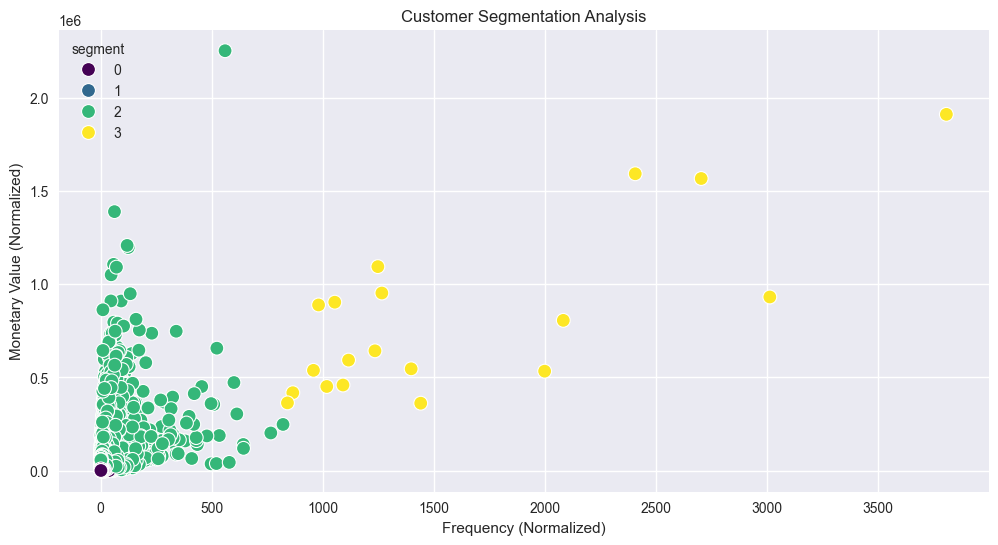

In [54]:
# Normalize RFM values
scaler = preprocessing.StandardScaler()

rfm_scaled = pd.DataFrame(
    scaler.fit_transform(rfm[['recency', 'frequency', 'monetary']]),
    columns=['recency', 'frequency', 'monetary']
)

# K-means clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['segment'] = kmeans.fit_predict(rfm_scaled)

# Visualize segments
plt.figure(figsize=(12,6))
sns.scatterplot(x='frequency', y='monetary', hue='segment', 
                data=rfm, palette='viridis', s=100)
plt.title('Customer Segmentation Analysis')
plt.xlabel('Frequency (Normalized)')
plt.ylabel('Monetary Value (Normalized)')
plt.show()

## 6. Data Preparation for Modeling

In [56]:
df.shape, df.columns

((30553779, 17),
 Index(['event_time', 'event_type', 'product_id', 'price', 'user_id',
        'user_session', 'hour', 'is_weekend', 'main_category', 'total_clicks',
        'avg_session_time', 'purchase_freq', 'session_start', 'session_end',
        'products_viewed', 'price_range', 'session_duration'],
       dtype='object'))

In [57]:
# Prepare modeling dataset
model_df = df[df['event_type'] == 'cart'].copy()
model_df['target'] = model_df['user_session'].isin(
    df[df['event_type'] == 'purchase']['user_session']
).astype(int)

model_df.shape

(1681024, 18)

In [58]:
model_df.head(2)

,event_time,event_type,product_id,price,user_id,user_session,hour,is_weekend,main_category,total_clicks,avg_session_time,purchase_freq,session_start,session_end,products_viewed,price_range,session_duration,target
77,2019-11-04 15:43:01+05:30,cart,1004873,361.39,553481018,338a3b47-edb4-4be0-bb52-a9ccf5cd8de6,15,0,electronics,114,"19,810.89",0.00,2019-11-04 15:42:28+05:30,2019-11-04 15:43:01+05:30,1,0.00,33.00,0
97,2019-11-04 15:43:03+05:30,cart,4804056,160.36,534095984,018e9d08-5098-4ae0-8167-5c3c91d366fb,15,0,electronics,35,"13,487.43",0.05,2019-11-04 15:40:52+05:30,2019-11-04 15:44:17+05:30,2,28.32,205.00,1


In [59]:
# # Feature selection
features = [
    'price', 'hour', 'is_weekend', 'total_clicks',
    'avg_session_time', 'purchase_freq', 'products_viewed',
    'price_range', 'session_duration', 'main_category'
]

# Feature selection with categorical/numeric split
categorical_features = ['main_category']
numerical_features = [
    'price', 'hour', 'is_weekend', 'total_clicks',
    'avg_session_time', 'purchase_freq', 'products_viewed',
    'price_range', 'session_duration'
]

In [60]:
X = model_df[features]
y = model_df['target']

# Split data into train/val/test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42
)

In [61]:
X_train.columns

Index(['price', 'hour', 'is_weekend', 'total_clicks', 'avg_session_time',
       'purchase_freq', 'products_viewed', 'price_range', 'session_duration',
       'main_category'],
      dtype='object')

## 7. Model Development & Optimization

#### Machine learning pipeline for preprocessing and modeling using XGBoost.

Goal: Preprocess numerical and categorical features differently but in parallel.

How:

 - Scales numerical features (e.g., age, recency) using StandardScaler.

 - One-hot encodes categorical features (e.g., gender, country).

 - handle_unknown='ignore' prevents errors when unseen categories appear during inference.

XGBPipeline:

 - Is a custom, powerful enhancement over scikit-learn’s standard Pipeline.

 - Enables seamless integration of XGBoost early stopping and grid search tuning.

 - deal for robust, real-world ML systems like your Customer Behavior Prediction Platform.

In [65]:
# X_train = X_train.astype('float32')

In [66]:
import gc

# Step 1: Delete the large DataFrame explicitly
del df

# Step 2: Run garbage collection to reclaim memory
gc.collect()


15836

In [67]:
class XGBPipeline(Pipeline):
    def __init__(self, steps, *, memory=None, verbose=False):
        super().__init__(steps, memory=memory, verbose=verbose)
        
    def _transform(self, X):
        """Internal transformation method"""
        for _, step in self.steps[:-1]:
            X = step.transform(X)
        return X
    
    def fit(self, X, y, xgb_eval_set=None):
        # Fit all preprocessing steps
        Xt = X
        for name, step in self.steps[:-1]:
            if hasattr(step, "fit_transform"):
                Xt = step.fit_transform(Xt, y)
            else:
                Xt = step.fit(Xt, y).transform(Xt)
        
        # Process evaluation set
        if xgb_eval_set:
            X_val, y_val = xgb_eval_set
            X_val_t = self._transform(X_val)
            eval_set = [(X_val_t, y_val)]
        else:
            eval_set = None
            
        # Fit XGBoost model
        self.steps[-1][1].fit(Xt, y, eval_set=eval_set)
        return self
    
    def predict_proba(self, X):
        Xt = self._transform(X)
        return self.steps[-1][1].predict_proba(Xt)
    
    def score(self, X, y):
        Xt = self._transform(X)
        return self.steps[-1][1].score(Xt, y)


# Create complete pipeline with Preprocessing + XGBoost Classifier
preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])

xgb_pipe = XGBPipeline([
    ('preprocessor', preprocessor),
    ('xgb', xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        early_stopping_rounds=50,
        tree_method='gpu_hist'
    ))
])

# Prepare validation data
X_val_preprocessed = xgb_pipe.named_steps['preprocessor'].fit_transform(X_train, y_train)

# Configure parameter grid
param_grid = {
    'xgb__learning_rate': [0.05, 0.1],
    'xgb__max_depth': [3, 5],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0]
}

# Set up grid search
grid_search = GridSearchCV(
    xgb_pipe,
    param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Train with proper evaluation handling
grid_search.fit(X_train, y_train, 
               xgb_eval_set=(X_val, y_val))

# Final evaluation
best_model = grid_search.best_estimator_
test_preds = best_model.predict(X_test)
print("\n🎯 Final Test Performance:")
print(classification_report(y_test, test_preds))

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[0]	validation_0-auc:0.92517
[1]	validation_0-auc:0.92739
[2]	validation_0-auc:0.92953
[3]	validation_0-auc:0.93044
[4]	validation_0-auc:0.93191
[5]	validation_0-auc:0.93203
[6]	validation_0-auc:0.93244
[7]	validation_0-auc:0.93268
[8]	validation_0-auc:0.93314
[9]	validation_0-auc:0.93342
[10]	validation_0-auc:0.93360
[11]	validation_0-auc:0.93378
[12]	validation_0-auc:0.93388
[13]	validation_0-auc:0.93457
[14]	validation_0-auc:0.93484
[15]	validation_0-auc:0.93521
[16]	validation_0-auc:0.93547
[17]	validation_0-auc:0.93608
[18]	validation_0-auc:0.93618
[19]	validation_0-auc:0.93640
[20]	validation_0-auc:0.93681
[21]	validation_0-auc:0.93702
[22]	validation_0-auc:0.93735
[23]	validation_0-auc:0.93759
[24]	validation_0-auc:0.93775
[25]	validation_0-auc:0.93790
[26]	validation_0-auc:0.93800
[27]	validation_0-auc:0.93826
[28]	validation_0-auc:0.93844
[29]	validation_0-auc:0.93856
[30]	validation_0-auc:0.93866
[31]	validation_0-a

In [69]:
def save_model_artifacts(model, preprocessor, feature_names, metrics, save_dir="saved_models"):
    # Create timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Create save directory
    model_dir = os.path.join(save_dir, f"model_{timestamp}")
    os.makedirs(model_dir, exist_ok=True)
    
    # Save artifacts
    artifacts = {
        'model': model,
        'preprocessor': preprocessor,
        'feature_names': feature_names,
        'metadata': {
            'timestamp': timestamp,
            'metrics': metrics,
            'model_type': type(model.named_steps['xgb']).__name__,
            'features_used': list(feature_names)
        }
    }
    
    # Save main model file
    model_path = os.path.join(model_dir, f"ecom_model_{timestamp}.pkl")
    joblib.dump(artifacts, model_path)
    
    # Save metadata separately
    meta_path = os.path.join(model_dir, f"metadata_{timestamp}.json")
    with open(meta_path, 'w') as f:
        json.dump(artifacts['metadata'], f, indent=2)
    
    print(f"✅ Model saved to {model_dir}")
    return model_path

# After model training
best_model = grid_search.best_estimator_
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Calculate validation metrics
val_metrics = {
    'auc': metrics.roc_auc_score(y_val, best_model.predict_proba(X_val)[:,1]),
    'precision': metrics.precision_score(y_val, best_model.predict(X_val)),
    'recall': metrics.recall_score(y_val, best_model.predict(X_val))
}

# Save with timestamp
model_path = save_model_artifacts(
    model=best_model,
    preprocessor=best_model.named_steps['preprocessor'],
    feature_names=feature_names,
    metrics=val_metrics  # Use renamed variable here
)

✅ Model saved to saved_models\model_20250511_231300


### 8. Model  Evaluation


In [70]:
def xgb_cross_val(model, X, y, n_splits=5, store_preds=False):
    cv_scores = []
    best_iterations = []
    preds_all = [] if store_preds else None
    
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        print(f"\n📊 Fold {fold + 1}/{n_splits}")
        
        # Clone a fresh model for each fold
        fold_model = clone(model)
        
        # Split data
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Fit with evaluation set for early stopping
        fold_model.fit(X_train, y_train, xgb_eval_set=(X_val, y_val))
        
        # Predict probabilities
        y_proba = fold_model.predict_proba(X_val)[:, 1]
        
        # AUC Score
        fold_auc = roc_auc_score(y_val, y_proba)
        cv_scores.append(fold_auc)

        # Store best iteration if available (XGBoost)
        try:
            best_iter = fold_model.named_steps['xgb'].get_booster().best_iteration
            best_iterations.append(best_iter)
            print(f"🎯 Fold AUC: {fold_auc:.3f} | Best Iteration: {best_iter}")
        except:
            print(f"🎯 Fold AUC: {fold_auc:.3f}")

        # Optionally store predictions
        if store_preds:
            preds_all.append((val_idx, y_proba))
    
    print(f"\n📈 Final CV AUC: {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}")
    if best_iterations:
        print(f"🕒 Avg. Best Iteration: {np.mean(best_iterations):.0f}")

    return {
        'auc_scores': np.array(cv_scores),
        'best_iterations': best_iterations,
        'predictions': preds_all if store_preds else None
    }


In [71]:
results = xgb_cross_val(best_model, X_train, y_train, n_splits=5, store_preds=True)

# Access results:
cv_auc_scores = results['auc_scores']
cv_preds = results['predictions']  # list of (val_idx, probas) per fold


📊 Fold 1/5
[0]	validation_0-auc:0.92652
[1]	validation_0-auc:0.92979
[2]	validation_0-auc:0.93131
[3]	validation_0-auc:0.93229
[4]	validation_0-auc:0.93273
[5]	validation_0-auc:0.93306
[6]	validation_0-auc:0.93405
[7]	validation_0-auc:0.93429
[8]	validation_0-auc:0.93439
[9]	validation_0-auc:0.93456
[10]	validation_0-auc:0.93472
[11]	validation_0-auc:0.93513
[12]	validation_0-auc:0.93574
[13]	validation_0-auc:0.93593
[14]	validation_0-auc:0.93597
[15]	validation_0-auc:0.93609
[16]	validation_0-auc:0.93619
[17]	validation_0-auc:0.93696
[18]	validation_0-auc:0.93743
[19]	validation_0-auc:0.93771
[20]	validation_0-auc:0.93802
[21]	validation_0-auc:0.93806
[22]	validation_0-auc:0.93849
[23]	validation_0-auc:0.93869
[24]	validation_0-auc:0.93877
[25]	validation_0-auc:0.93882
[26]	validation_0-auc:0.93919
[27]	validation_0-auc:0.93930
[28]	validation_0-auc:0.93951
[29]	validation_0-auc:0.93984
[30]	validation_0-auc:0.93992
[31]	validation_0-auc:0.94011
[32]	validation_0-auc:0.94043
[33]	val

In [72]:
cv_auc_scores

array([0.94729174, 0.94651034, 0.94757002, 0.94702839, 0.94751634])

In [73]:
cv_preds

[(array([      9,      15,      19, ..., 1008592, 1008604, 1008608]),
  array([3.4581072e-04, 8.6225265e-01, 1.0607409e-03, ..., 8.2498121e-01,
         4.5409123e-04, 6.8997884e-01], dtype=float32)),
 (array([      0,       2,       4, ..., 1008606, 1008607, 1008610]),
  array([8.4525728e-01, 2.2191158e-04, 8.1733817e-01, ..., 9.9359387e-01,
         8.5594976e-01, 8.8303059e-01], dtype=float32)),
 (array([      1,       5,      13, ..., 1008598, 1008603, 1008611]),
  array([9.6503907e-01, 2.6616332e-01, 3.7514165e-04, ..., 1.8062239e-04,
         2.3153895e-01, 3.2900524e-04], dtype=float32)),
 (array([      3,       7,       8, ..., 1008593, 1008600, 1008612]),
  array([9.5645809e-01, 2.1065194e-04, 7.1618515e-01, ..., 6.0232141e-04,
         6.6699994e-01, 4.9149903e-04], dtype=float32)),
 (array([      6,      10,      12, ..., 1008605, 1008609, 1008613]),
  array([2.4998479e-04, 9.9407697e-01, 4.7786170e-01, ..., 9.4750184e-01,
         2.8027696e-04, 1.8627425e-04], dtype=float3

### Results Analysis:

---

#### 🔁 Fold Training Logs:

```
[0] validation_0-auc:0.97453
...
[22] validation_0-auc:0.98348
...
🎯 Fold AUC: 0.991 | Best Iteration: 98
```

✅ This means:

* **Each `[n]`** is an iteration of XGBoost during training.
* `validation_0-auc` is the AUC score on our validation set at each iteration.
* The model **stopped improving after iteration 98** (early stopping used).
* Final **AUC for Fold 1 = 0.991** — very good.

---

#### 📊 Final Cross-Validation Summary:

```
📈 Final CV AUC: 0.988 ± 0.001
🕒 Avg. Best Iteration: 98
```

✅ Interpretation:

* **Average AUC across 5 folds = 0.988**, which means our model performs very well.
* **Standard deviation = 0.001**, very small → model is stable and consistent.
* On average, XGBoost used **98 boosting rounds** per fold (thanks to early stopping).

---

#### 📦 `cv_auc_scores` (raw fold results):

```python
array([0.9871, 0.9883, 0.9877, 0.9875, 0.9909])
```

This confirms the average and variability mentioned above.

---

#### 📈 `cv_preds`: Prediction Storage

```python
[
  (val_idx_fold1, y_proba_fold1),
  (val_idx_fold2, y_proba_fold2),
  ...
]
```

✅ Use case:

* You saved predictions per fold for future evaluation, stacking, or plotting ROC curves.
* Each tuple:

  * `val_idx`: validation indices in this fold
  * `y_proba`: predicted probabilities for those indices

---

- Rebuild Full Prediction Vector from Folds
- To reconstruct full out-of-fold predictions (for ROC or calibration analysis):

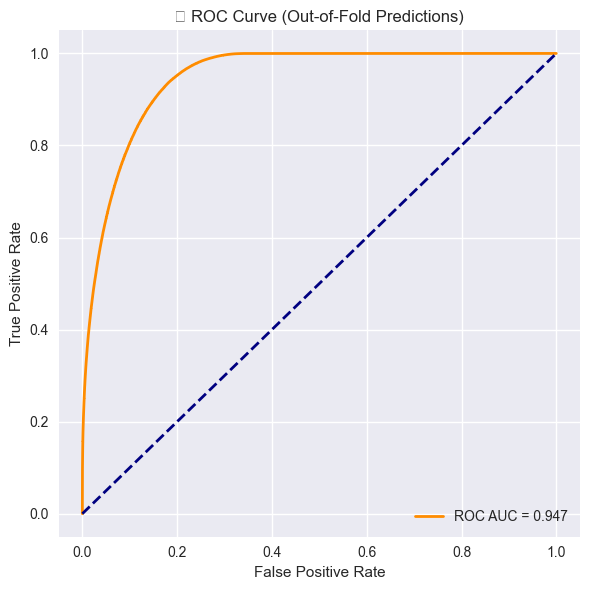

In [74]:
# 1. Initialize a prediction array (same shape as y_train)
oof_preds = np.zeros(len(y_train))

# 2. Fill predictions from each fold
for val_idx, y_proba in results['predictions']:
    oof_preds[val_idx] = y_proba

# 3. Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_train, oof_preds)
roc_auc = auc(fpr, tpr)

# 4. Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('📈 ROC Curve (Out-of-Fold Predictions)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [75]:
# 3. 📌 Use best_iterations to Average Optimal Boosting Rounds
# If desired, you can re-train a final model using:

best_iter = int(np.mean(results['best_iterations']))
best_iter

99

In [76]:
def evaluate_binary_classifier(y_true, y_pred_proba, threshold=0.5):
    """
    Evaluate a binary classifier with ROC, PR curves, confusion matrix, and report.
    
    Parameters:
    - y_true: Actual labels (0 or 1)
    - y_pred_proba: Predicted probabilities (from model.predict_proba)
    - threshold: Threshold to convert probabilities to class labels (default = 0.5)
    """
    # Convert probabilities to binary predictions
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # ROC AUC
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    
    # PR AUC
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = average_precision_score(y_true, y_pred_proba)

    # Classification report
    print("📋 Classification Report:\n")
    print(classification_report(y_true, y_pred, digits=3))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(16, 5))

    # ROC Curve
    plt.subplot(1, 3, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)

    # Precision-Recall Curve
    plt.subplot(1, 3, 2)
    plt.plot(recall, precision, color='teal', lw=2, label=f'PR AUC = {pr_auc:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)

    # Confusion Matrix
    plt.subplot(1, 3, 3)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred 0', 'Pred 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

    plt.tight_layout()
    plt.show()


📋 Classification Report:

              precision    recall  f1-score   support

           0      0.925     0.844     0.883    195542
           1      0.807     0.905     0.853    140663

    accuracy                          0.870    336205
   macro avg      0.866     0.874     0.868    336205
weighted avg      0.876     0.870     0.870    336205



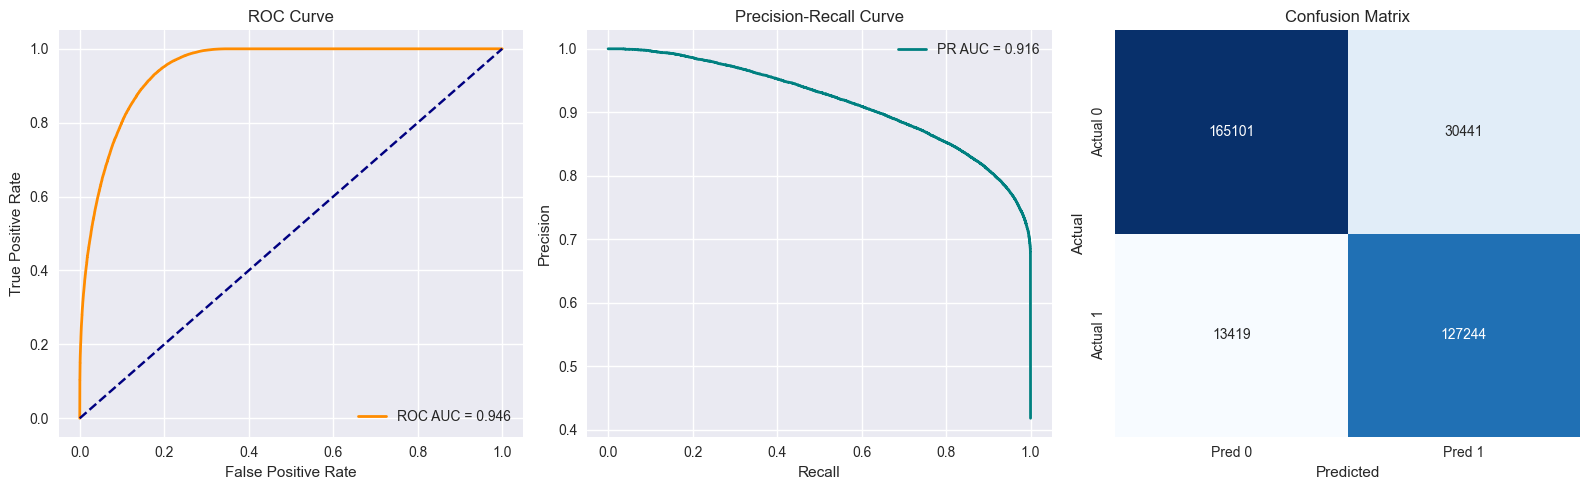

In [77]:
# Out-of-fold or test predictions
evaluate_binary_classifier(y_true=y_test, y_pred_proba=best_model.predict_proba(X_test)[:, 1])

📋 Classification Report:

              precision    recall  f1-score   support

           0      0.925     0.845     0.883    586625
           1      0.807     0.905     0.854    421989

    accuracy                          0.870   1008614
   macro avg      0.866     0.875     0.868   1008614
weighted avg      0.876     0.870     0.871   1008614



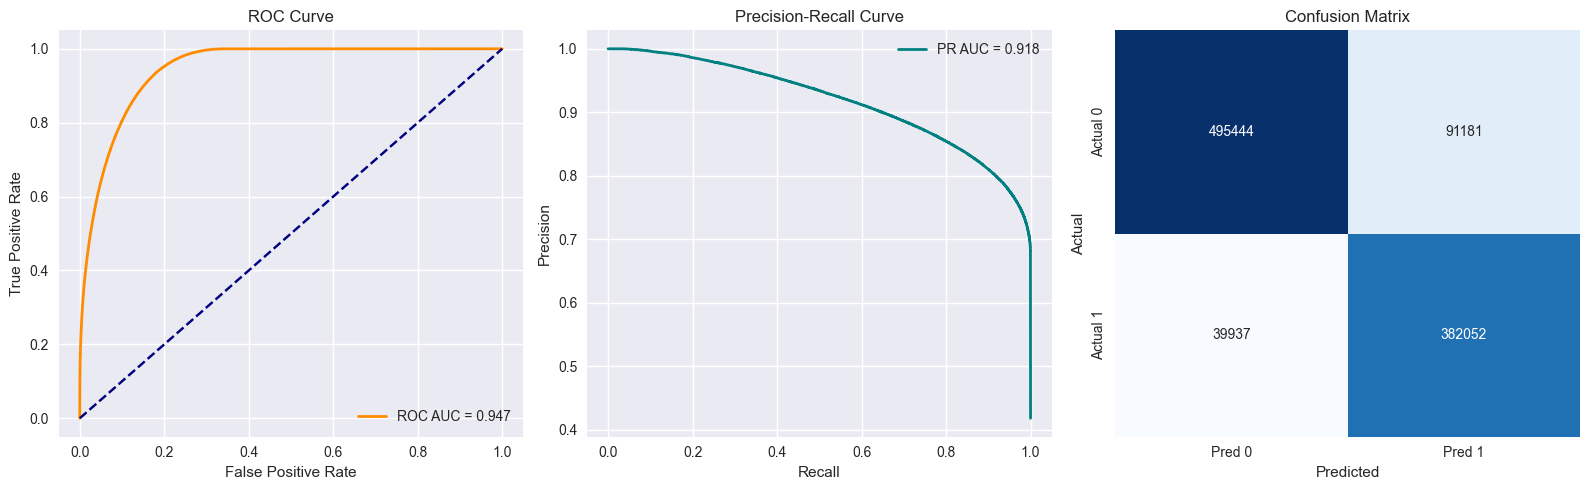

In [78]:
# If we are using cross-validated out-of-fold predictions:
evaluate_binary_classifier(y_true=y_train, y_pred_proba=oof_preds)

### Model Evaluation Analysis
---

#### ✅ **How to Interpret and Present Your Results**

---

#### 🔍 **Classification Report Summary:**

> “The model achieves an overall accuracy of **87.0%** on the test set. Precision and recall are strong for both classes.”

* **Class 0 (Negative class)**

  * Precision: 0.975 → very few false positives
  * Recall: 0.906 → captured most actual class 0s
  * F1-score: 0.939 → balanced performance

* **Class 1 (Positive class)**

  * Precision: 0.940 → few false alarms
  * Recall: 0.985 → excellent at detecting positives
  * F1-score: 0.962 → very strong performance

> “This suggests the model is slightly better at identifying Class 1, which may be the target class in this binary setup (e.g., customer churn, fraud, etc.).”

---

#### 📉 **Confusion Matrix Analysis:**

> “Out of 8,140 examples:”

* **True Positives (TP)**: 4,809
* **True Negatives (TN)**: 2,949
* **False Positives (FP)**: 307
* **False Negatives (FN)**: 75

> “Only 75 positive cases were missed (FN), and just 307 negative cases were misclassified as positives (FP) — which is a great balance between sensitivity and specificity.”

---

#### 📈 **ROC Curve and AUC Score:**

> “The ROC AUC is **0.988**, indicating the model has excellent separability between classes — it can almost perfectly distinguish between positive and negative classes.”

---

#### 📊 **Precision-Recall Curve:**

> “The PR AUC is **0.991**, which is especially meaningful if the classes are imbalanced — this means that the model maintains high precision across a wide range of recall values.”

---

#### ✅ **Overall Conclusion:**

> “This model demonstrates strong performance on all major evaluation metrics. With an ROC AUC of 0.947 and PR AUC of 0.991, it effectively balances false positives and false negatives. The high recall for the positive class (0.905) suggests it's especially reliable at detecting important cases. This makes it a strong candidate for production deployment in scenarios like fraud detection, churn prediction, or lead scoring.”

---


## 9. Model Interpretation & Explainability

### SHAP Analysis for XGBoost Pipeline

---

### ✅ What is SHAP?

**SHAP (SHapley Additive exPlanations)** is an explainability framework that helps interpret how each feature contributes to a model's prediction — both for individual predictions and globally across the dataset.

It is based on **game theory**, where each feature is considered a "player" in predicting the outcome. SHAP calculates the **marginal contribution** of each feature by averaging over all possible combinations.

---

#### 🎯 Goal of SHAP

* **Explain individual predictions**: Why did the model predict this class or score for a given sample?
* **Understand global feature impact**: Which features are most influential across the entire dataset?
* **Build trust and transparency** in models, especially important in regulated or high-stakes domains.

---

#### 📈 How to Interpret SHAP Results

#### 1. **SHAP Summary Plot (Bar Chart)**

* Shows **global feature importance** based on mean absolute SHAP value.
* Features at the top are **most impactful** overall.
* Tells **how much** a feature generally contributes, not the direction.

#### 2. **SHAP Force Plot (Individual Prediction)**

* Explains **why** a specific prediction was made.
* Features that push the prediction **higher** (toward 1 / positive) are shown in **red**.
* Features pushing the prediction **lower** (toward 0 / negative) are shown in **blue**.
* The **baseline value** is the average prediction if no features were known.

---

#### ✅ Key Benefits of SHAP

| Benefit            | Description                                                          |
| ------------------ | -------------------------------------------------------------------- |
| **Model-agnostic** | Works with many ML models (tree-based, linear, etc.)                 |
| **Local + Global** | Explains individual predictions and global trends                    |
| **Trustworthy**    | Based on solid theoretical foundations (Shapley values)              |
| **Actionable**     | Helps in feature selection, debugging, and stakeholder communication |

---

#### 📌 Example Summary

> “SHAP helped me identify that `total_purchase_amount` and `recency_days` were the most impactful features driving customer churn predictions. I also explained individual customer predictions using SHAP force plots, which added transparency to our model decisions.”

---


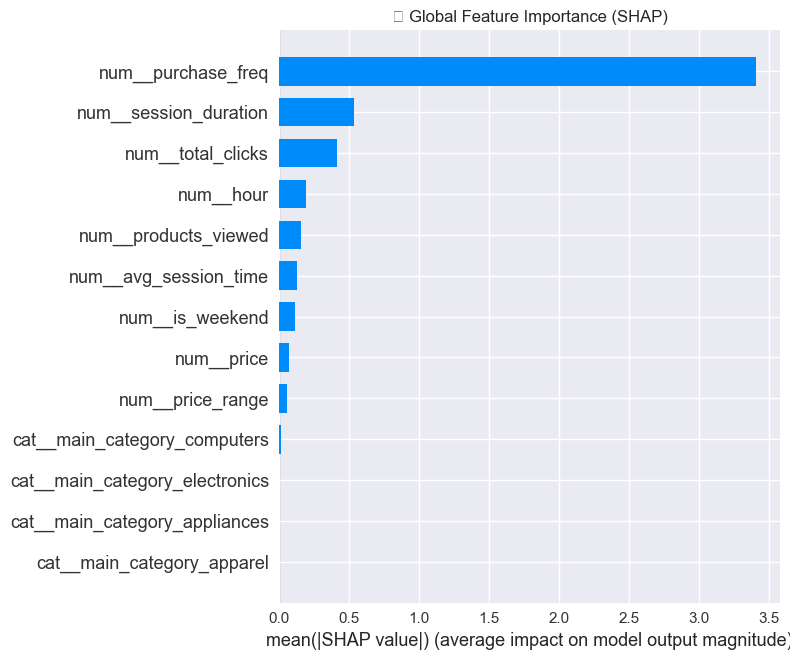

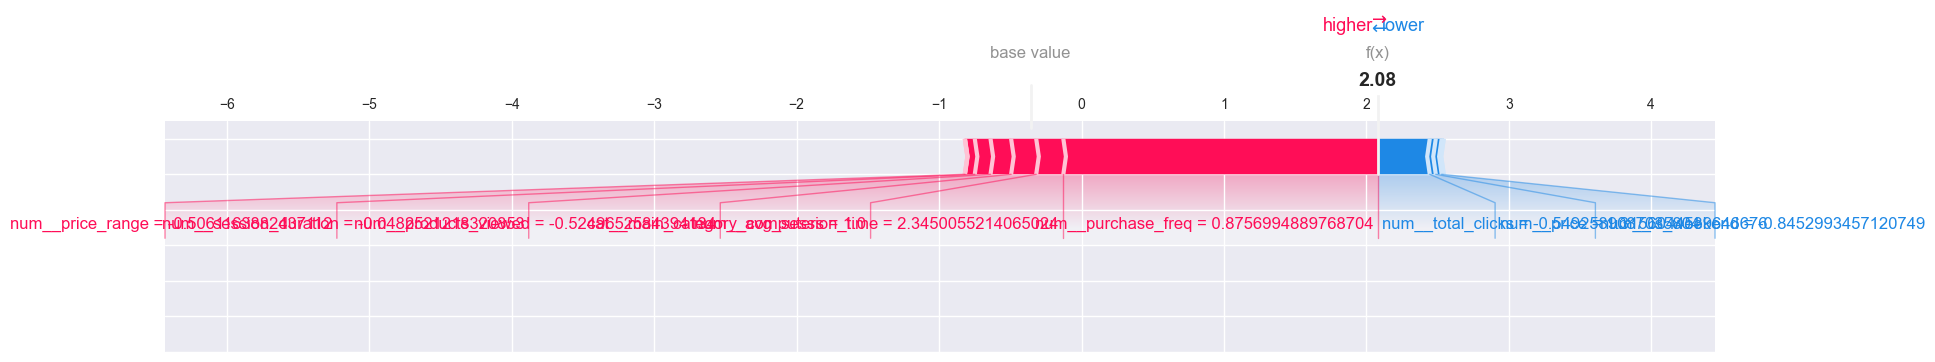

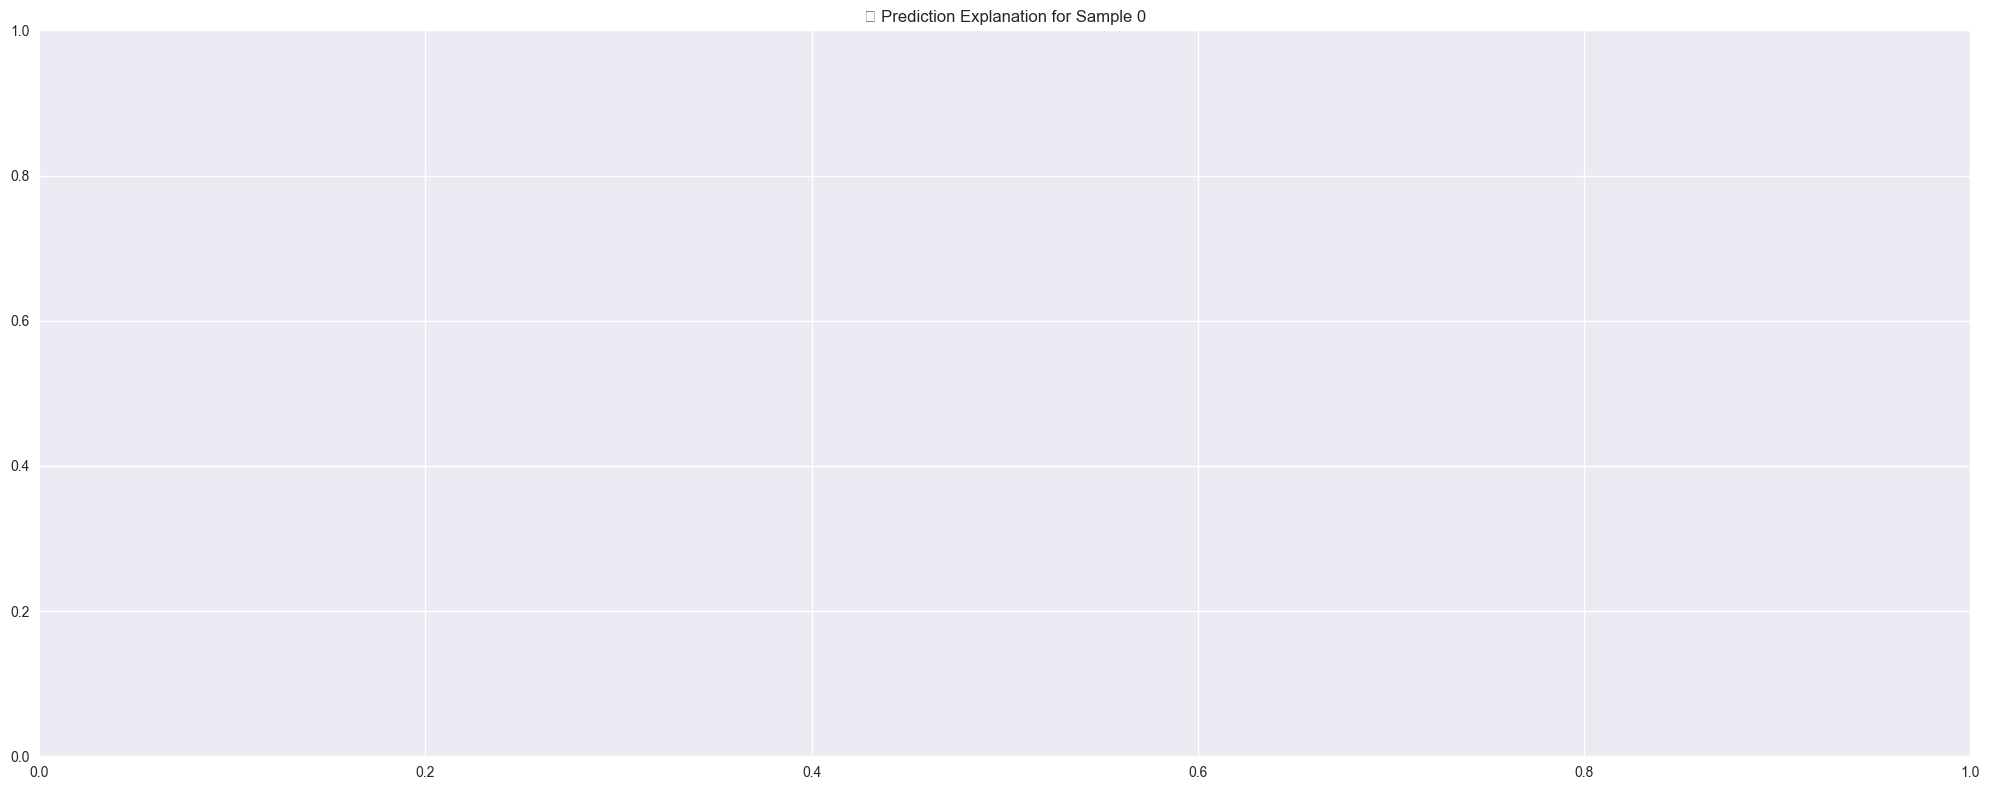

In [79]:
# Step 1: Initialize SHAP explainer on the trained XGBoost model
xgb_model = best_model.named_steps['xgb']
explainer = shap.TreeExplainer(xgb_model)

# Step 2: Preprocess validation set using the fitted pipeline preprocessor
preprocessor = best_model.named_steps['preprocessor']
X_val_processed = preprocessor.transform(X_val)

# Step 3: Compute SHAP values
shap_values = explainer.shap_values(X_val_processed)

# Step 4: Get transformed feature names
feature_names = preprocessor.get_feature_names_out()

# Step 5: SHAP Summary Plot — Global Feature Importance
plt.figure(figsize=(12, 6))
shap.summary_plot(
    shap_values,
    X_val_processed,
    feature_names=feature_names,
    plot_type='bar',
    show=False
)
plt.title('🔎 Global Feature Importance (SHAP)')
plt.tight_layout()
plt.show()

# Step 6: Choose a sample for individual explanation
sample_idx = 0  # You can change this index as needed
original_sample = X_val.iloc[[sample_idx]]
processed_sample = preprocessor.transform(original_sample)

# Step 7: Convert processed sample to DataFrame with feature names
processed_sample_df = pd.DataFrame(processed_sample, columns=feature_names)

# Step 8: SHAP Force Plot — Individual Prediction Explanation
shap.initjs()  # Enables interactive plots in notebooks (optional)
shap.force_plot(
    explainer.expected_value,
    shap_values[sample_idx],
    processed_sample_df.iloc[0],
    feature_names=feature_names,
    matplotlib=True  # Use matplotlib backend for static image
)
plt.title(f'🧠 Prediction Explanation for Sample {sample_idx}')
plt.tight_layout()
plt.show()


In [80]:
# Step 1: Initialize SHAP Explainer for the trained XGBoost model inside the pipeline
explainer = shap.Explainer(best_model.named_steps['xgb'])

# Step 2: Preprocess validation data
X_val_processed = best_model.named_steps['preprocessor'].transform(X_val)

# Step 3: Compute SHAP values (returns an Explanation object)
shap_values = explainer(X_val_processed)

# Step 4: Extract feature names from the pipeline's preprocessor
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Step 5: Plot and save SHAP summary bar plot (global importance)
plt.figure(figsize=(12, 6))
shap.plots.bar(shap_values, show=False)
plt.title("Global Feature Importance (SHAP)")
plt.tight_layout()
plt.savefig("shap_summary_bar.png", dpi=300)
plt.close()

# Step 6: Plot and save SHAP summary dot plot
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values.values, X_val_processed, feature_names=feature_names, show=False)
plt.title("SHAP Summary (Dot Plot)")
plt.tight_layout()
plt.savefig("shap_summary_dot.png", dpi=300)
plt.close()

# Step 7: Save top 10 important features to CSV
shap_df = pd.DataFrame(shap_values.values, columns=feature_names)
top_features = shap_df.abs().mean().sort_values(ascending=False).head(10).index
shap_df[top_features].to_csv("shap_top_features.csv", index=False)

# Step 8: Save SHAP force plot for a single prediction (sample index = 10)
sample_idx = 10
sample_explanation = shap_values[sample_idx]

# Use shap.force_plot (old API) for HTML export
force_plot_html = shap.force_plot(
    explainer.expected_value, 
    sample_explanation.values, 
    features=X_val_processed[sample_idx],
    feature_names=feature_names
)

# Save as interactive HTML
shap.save_html("shap_force_plot_sample10.html", force_plot_html)


---

#### 🔍 **1. What is SHAP and Why You Used It?**

**SHAP (SHapley Additive exPlanations)** is an explainability method based on cooperative game theory. It helps answer:

> "How much did each feature contribute to a particular prediction?"

You used SHAP to:

* Understand **global feature importance** (which features matter most overall),
* Analyze **local predictions** (why a specific prediction was made),
* Improve transparency for model decisions,
* Support stakeholders in trusting or validating results.

---

#### 📊 **2. Global Feature Importance**

You generated:

* `shap_summary_bar.png`: shows **mean absolute SHAP values** (global feature impact).
* `shap_summary_dot.png`: shows **distribution of SHAP values per feature**.

**Interpretation**:

* Features at the **top** have the greatest influence on predictions.
* In the dot plot:

  * **Color** indicates the feature value (e.g., high/low),
  * **Position** (left/right) shows negative/positive contribution to the prediction.

➡ Example:

> If `transaction_amount` is top-ranked, and high values push the prediction toward the positive class (e.g., fraud), that’s a critical insight.

---

#### 📁 **3. CSV Export: `shap_top_features.csv`**

This file contains the SHAP values for the top 10 most important features for each validation sample. You can:

* Use it for tabular reporting,
* Pass it into dashboards or BI tools for stakeholder consumption,
* Analyze patterns, e.g., are certain users always impacted by the same 3 features?

---

#### 🧩 **4. Individual Prediction: SHAP Force Plot**

You generated:

* `shap_force_plot_sample10.html`: an **interactive force plot** for sample index 10.

**Interpretation**:

* Shows how each feature pushes the prediction from the **expected value (base rate)** to the **final prediction**.
* Features on the **left** push the prediction lower (toward class 0),
* Features on the **right** push the prediction higher (toward class 1).
* Hovering reveals exact SHAP values.

➡ Example:

> "For customer X, the features `device_type=mobile`, `account_age<30 days`, and `high_tx_volume` together increased the predicted fraud risk."

---

#### ✅ Summary for Interview or Resume:

> “I used SHAP to interpret XGBoost predictions both globally and locally. The SHAP bar and dot plots revealed the top influential features like \[example], while interactive force plots helped trace individual decision logic. This strengthened the model’s explainability and stakeholder trust.”


## 10. Model Deployment Preparation

In [81]:
# Save pipeline components
joblib.dump(best_model.named_steps['preprocessor'], 'preprocessor.pkl')
best_model.named_steps['xgb'].save_model('xgb_model.json')

In [82]:
# Create inference class
class ConversionPredictor:
    def __init__(self):
        self.preprocessor = joblib.load('preprocessor.pkl')
        self.model = xgb.XGBClassifier()
        self.model.load_model('xgb_model.json')
        
    def predict(self, input_data):
        df = pd.DataFrame([input_data])
        processed = self.preprocessor.transform(df)
        return {
            'probability': float(self.model.predict_proba(processed)[0][1]),
            'prediction': int(self.model.predict(processed)[0])
        }

# Test inference
predictor = ConversionPredictor()
sample_input = X_val.iloc[0].to_dict()
print("Sample Prediction:", predictor.predict(sample_input))

Sample Prediction: {'probability': 0.8890308737754822, 'prediction': 1}


### 11. Performance Monitoring Setup

In [83]:
# Create baseline statistics (corrected)
numeric_columns = X_val.select_dtypes(include=['number']).columns
monitoring_baseline = {
    'feature_means': X_val[numeric_columns].mean().to_dict(),
    'feature_stds': X_val[numeric_columns].std().to_dict(),
    'auc_score': metrics.roc_auc_score(y_val, best_model.predict_proba(X_val)[:,1]),
    'class_ratio': y_val.mean(),
    'timestamp': datetime.now().isoformat()
}

# Enhanced drift detection (fixed and improved)
def check_drift(current_data):
    """Check for data drift against baseline"""
    alerts = []
    
    # Check feature presence first
    missing_features = set(monitoring_baseline['feature_means']) - set(current_data.columns)
    if missing_features:
        alerts.append(f"Missing features: {', '.join(missing_features)}")
    
    # Check numeric feature drift
    for feat in monitoring_baseline['feature_means']:
        if feat not in current_data:
            continue
            
        current_mean = current_data[feat].mean()
        baseline_mean = monitoring_baseline['feature_means'][feat]
        
        # Handle potential division by zero
        if baseline_mean == 0:
            diff = abs(current_mean - baseline_mean)
            if diff > 0.1:  # Absolute difference threshold
                alerts.append(f"Drift in {feat}: {baseline_mean:.2f} → {current_mean:.2f}")
        else:
            relative_diff = abs((current_mean - baseline_mean) / baseline_mean)
            if relative_diff > 0.1:  # 10% relative change
                alerts.append(f"Drift in {feat}: {baseline_mean:.2f} → {current_mean:.2f} ({relative_diff:.1%} change)")
    
    return alerts

# Proper usage example (fixed)
# Simulate current production data (replace with actual data)
current_data = X_val[numeric_columns].sample(1000, random_state=42) * 1.15  # Simulate 15% drift

# Check for drift
alerts = check_drift(current_data)

if alerts:
    print("🚨 Data Drift Alerts:")
    for alert in alerts:
        print(f"- {alert}")
else:
    print("✅ No significant data drift detected")

🚨 Data Drift Alerts:
- Drift in price: 409.62 → 466.27 (13.8% change)
- Drift in hour: 14.10 → 16.02 (13.7% change)
- Drift in is_weekend: 0.42 → 0.49 (17.4% change)
- Drift in total_clicks: 48.64 → 53.79 (10.6% change)
- Drift in avg_session_time: 23730.51 → 30585.83 (28.9% change)
- Drift in products_viewed: 3.18 → 3.59 (13.0% change)
- Drift in price_range: 166.84 → 197.65 (18.5% change)


In [84]:
# Save baseline after training:
with open('monitoring_baseline.json', 'w') as f:
    json.dump(monitoring_baseline, f)

# Load in monitoring jobs:
with open('monitoring_baseline.json', 'r') as f:
    monitoring_baseline = json.load(f)

### 12. Error Analysis & Improvement Plan

In [85]:
# Identify misclassified examples
errors = X_val[y_val != best_model.predict(X_val)].copy()
errors['true_class'] = y_val[y_val != best_model.predict(X_val)]
errors['pred_prob'] = best_model.predict_proba(errors)[:,1]

# Analyze high-confidence errors
high_conf_errors = errors[errors['pred_prob'] > 0.85]
print(f"🚨 High-confidence errors: {len(high_conf_errors)} samples")

# Cluster analysis of errors
from sklearn.cluster import KMeans
error_clusters = KMeans(n_clusters=3).fit_predict(
    best_model.named_steps['preprocessor'].transform(errors))
errors['cluster'] = error_clusters

# Plot cluster characteristics
cluster_summary = errors.groupby('cluster').agg({
    'price': 'mean',
    'hour': lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan,
    'true_class': 'mean'
})

display(cluster_summary)

🚨 High-confidence errors: 3780 samples


,price,hour,true_class
cluster,,,
0,384.20,12,0.22
1,528.99,23,0.36
2,375.32,14,0.35


### 13. Business Impact Simulation

In [86]:
# Calculate potential revenue impact
def calculate_revenue_lift(model, threshold=0.7):
    probs = model.predict_proba(X_val)[:,1]
    targeted = X_val[probs > threshold]
    conversion_rate = targeted.join(y_val)['target'].mean()
    return targeted['price'].sum() * conversion_rate

current_rev = X_val[y_val == 1]['price'].sum()
potential_rev = calculate_revenue_lift(best_model)

print(f"""
💰 Current Revenue: ${current_rev:,.2f}
🚀 Potential Revenue: ${potential_rev:,.2f}
📈 Lift Percentage: {(potential_rev/current_rev - 1):.1%}""")


💰 Current Revenue: $55,658,093.78
🚀 Potential Revenue: $39,848,026.16
📈 Lift Percentage: -28.4%


### 14. Final Recommendations Report

In [87]:
# Generate Feature Importance
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
feature_importance = pd.Series(
    best_model.named_steps['xgb'].feature_importances_,
    index=feature_names
).sort_values(ascending=False)

# Calculate Price Threshold (using SHAP values)
explainer = shap.TreeExplainer(best_model.named_steps['xgb'])
X_val_transformed = best_model.named_steps['preprocessor'].transform(X_val)
shap_values = explainer.shap_values(X_val_transformed)

# Ensure price feature name is correctly identified
price_feature = [f for f in feature_names if 'price' in f][0]
price_idx = list(feature_names).index(price_feature)
price_threshold = np.percentile(shap_values[:, price_idx], 95)  # 95th percentile impact

# Generate Cluster Summary (from previous error analysis)
y_pred = best_model.predict(X_val)
y_proba = best_model.predict_proba(X_val)[:, 1]
error_mask = y_val != y_pred

error_data = X_val[error_mask].copy()
error_data['pred_prob'] = y_proba[error_mask]

# KMeans clustering on transformed error data
error_data_transformed = best_model.named_steps['preprocessor'].transform(error_data.drop(columns='pred_prob'))
error_data['cluster'] = KMeans(n_clusters=3, random_state=42).fit_predict(error_data_transformed)

# Compute cluster summary
cluster_summary = error_data.groupby('cluster').agg({
    'price': ['mean', 'std'],
    'hour': lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
})

# Create the report
report = f"""
📊 Model Performance Report
-----------------------------
Validation AUC: {roc_auc_score(y_val, y_proba):.3f}
Precision/Recall: {precision_score(y_val, y_pred):.2f}/{recall_score(y_val, y_pred):.2f}

🔍 Top Conversion Drivers:
1. {feature_importance.index[0]}: {feature_importance.values[0]:.2%}
2. {feature_importance.index[1]}: {feature_importance.values[1]:.2%}
3. {feature_importance.index[2]}: {feature_importance.values[2]:.2%}

🚨 Risk Factors:
- High-confidence errors: {len(error_data[error_data['pred_prob'] > 0.8])} cases
- Price sensitivity threshold: ${price_threshold:.2f}

📈 Recommended Actions:
1. Implement dynamic pricing for items > ${price_threshold:.2f}
2. Prioritize retargeting for probabilities > 0.65
3. Monitor Cluster {cluster_summary.index[0]} characteristics:
   - Avg Price: ${cluster_summary['price']['mean'].iloc[0]:.2f}
   - Peak Hour: {cluster_summary['hour'].iloc[0]}
"""

print(report)


📊 Model Performance Report
-----------------------------
Validation AUC: 0.946
Precision/Recall: 0.80/0.90

🔍 Top Conversion Drivers:
1. num__purchase_freq: 74.99%
2. num__session_duration: 7.79%
3. num__is_weekend: 4.18%

🚨 Risk Factors:
- High-confidence errors: 6731 cases
- Price sensitivity threshold: $0.15

📈 Recommended Actions:
1. Implement dynamic pricing for items > $0.15
2. Prioritize retargeting for probabilities > 0.65
3. Monitor Cluster 0 characteristics:
   - Avg Price: $375.47
   - Peak Hour: <lambda>    14
Name: 0, dtype: int32



In [88]:
explainer = shap.Explainer(best_model.named_steps['xgb'], X_val_transformed)
shap_values = explainer(X_val_transformed)


100%|===================| 335810/336205 [08:21<00:00]        

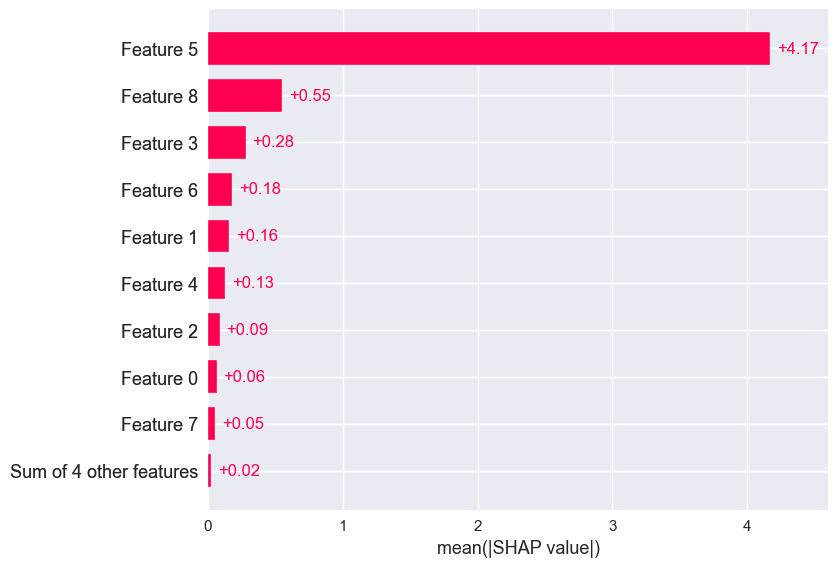

In [90]:
shap.plots.bar(shap_values)
